In [1]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


In [2]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

In [3]:
edispKernelMap = dataset_load.edisp
edispKernel = edispKernelMap.get_edisp_kernel()
edispMap = edispKernelMap.edisp_map

In [4]:
from astropy.visualization import quantity_support

def plot(edispKernel_):
    ax = plt.gca() 
    kwargs =dict()
    kwargs.setdefault("cmap", "GnBu")
    from matplotlib.colors import PowerNorm

    norm = PowerNorm(gamma=0.5, vmin=0, vmax=1)
    kwargs.setdefault("norm", norm)


    energy_axis_true = edispKernel.axes["energy_true"]
    energy_axis = edispKernel.axes["energy"]

    with quantity_support():
        caxes = ax.pcolormesh(
            energy_axis_true.edges, energy_axis.edges, edispKernel_.data.T, **kwargs
        )

    label = "Probability density (A.U.)"
    ax.figure.colorbar(caxes, ax=ax, label=label)

    energy_axis_true.format_plot_xaxis(ax=ax)
    energy_axis.format_plot_yaxis(ax=ax)

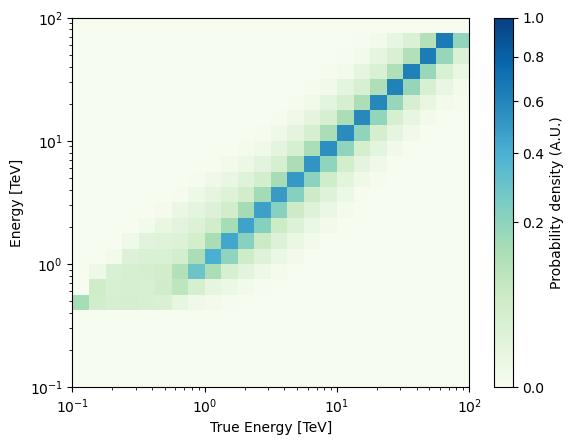

In [5]:
plot(edispKernel)

In [6]:
from gammapy.maps import MapAxis
from gammapy.irf import EDispKernel, EDispKernelMap
def get_gaussian_kernel(bias, sigma):
    edisp_kernel = EDispKernel.from_gauss(
        energy_axis_true=energy_true, energy_axis=energy, sigma=sigma, bias=bias
    )
    return edisp_kernel

In [7]:
energy = edispKernel.axes['energy']
energy_true = edispKernel.axes['energy_true']
bias = 0.1
sigma = 0.001



In [8]:
%%time
gaussian = get_gaussian_kernel(bias = bias, sigma = sigma)

CPU times: user 25.1 ms, sys: 4.21 ms, total: 29.3 ms
Wall time: 40 ms


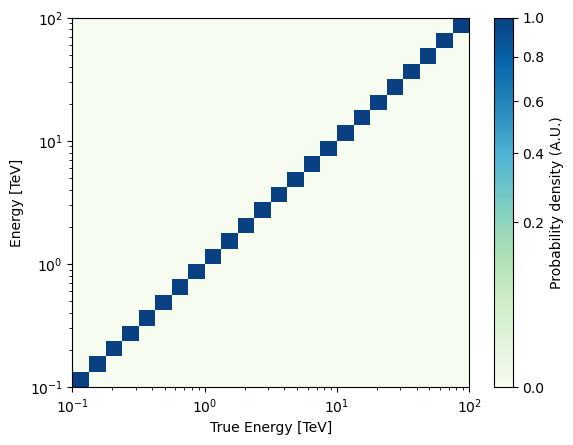

In [9]:
plot(gaussian)

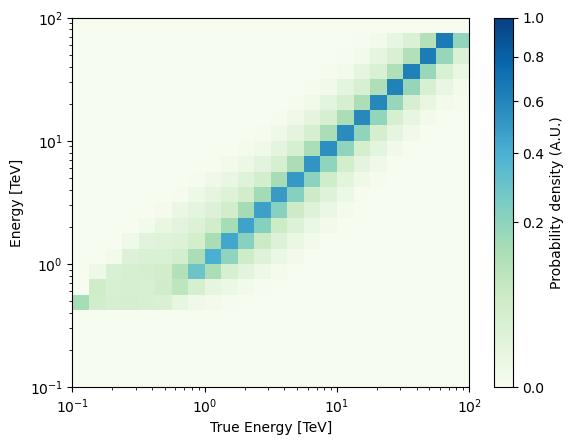

In [10]:
plot(edispKernel )

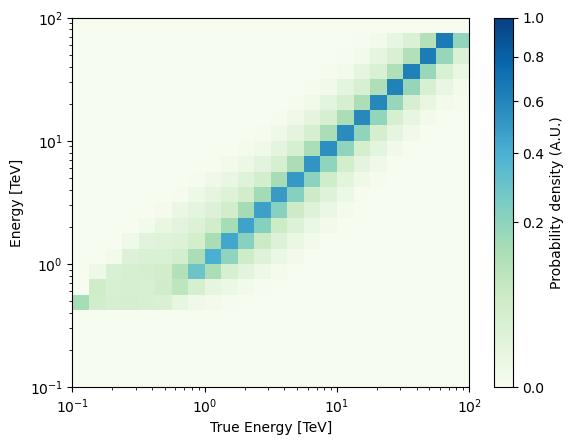

In [11]:
conv = EDispKernel(
         axes = edispKernel.axes,
         data = np.matmul(edispKernel.data, gaussian.data) )
plot(conv )

In [12]:
simulated_edisp_map = EDispKernelMap.from_edisp_kernel(conv)

dataset_conv = dataset_load.copy()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_conv.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_conv.models = models
dataset_conv
dataset_conv.edisp = simulated_edisp_map


In [13]:
def sum_e (data):
    return data.sum(axis=2).sum(axis=1)

eaxis_standard = dataset_load.geoms['geom'].axes[0]

Text(0.5, 0, 'Standard Energy [TeV]')

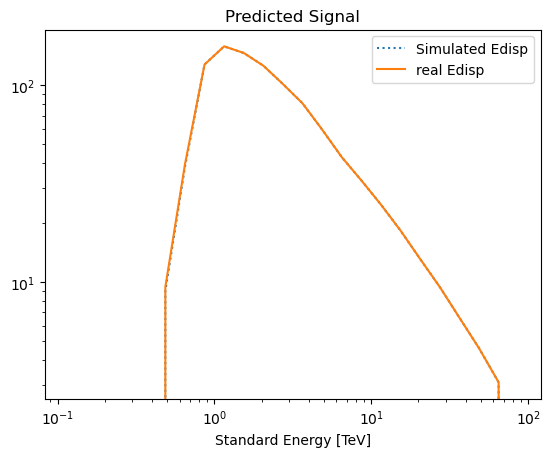

In [14]:
plt.title("Predicted Signal")
plt.plot(eaxis_standard.center, sum_e(dataset_conv.npred_signal().data), ':',label = "Simulated Edisp")
plt.plot(eaxis_standard.center, sum_e(dataset_load.npred_signal().data),  label = "real Edisp")
plt.loglog()
plt.legend()
plt.xlabel("Standard Energy [TeV]")

In [19]:
sys_d_cor = sys_dataset(dataset_asimov= dataset_load,
                        shift = 0, 
                        tilt = 0,
                        bias = 0.0000000001, 
                        sigma = 0.0000001, 
                        rnd = False)
dataset_cor_N = sys_d_cor.create_dataset_N()
print(dataset_cor_N.models)

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


convoluted


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


convoluted
DatasetModels

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.019   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : dataset N-bkg
  Datasets names            : ['dataset N']
  Spectral model type       : PowerLawNormSpectralMode

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/gammapy/gammapy/modeling/models/spatial.py:555: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


In [20]:
#dataset_cor_N.models[-1].parameters['bias'].value = 0.5
dataset_cor_N.npred_edisp()

convoluted


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


convoluted


Text(0.5, 0, 'Standard Energy [TeV]')

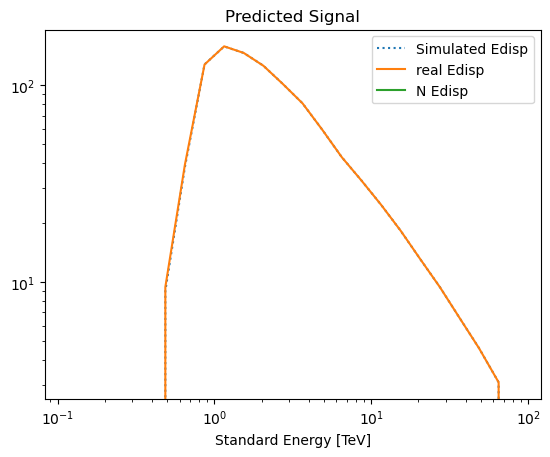

In [21]:
plt.title("Predicted Signal")
plt.plot(eaxis_standard.center, sum_e(dataset_conv.npred_signal().data), ':',label = "Simulated Edisp")
plt.plot(eaxis_standard.center, sum_e(dataset_load.npred_signal().data),  label = "real Edisp")
plt.plot(eaxis_standard.center, sum_e(dataset_cor_N.npred_signal().data),  label = "N Edisp")

plt.loglog()
plt.legend()
plt.xlabel("Standard Energy [TeV]")

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


convoluted


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


convoluted


(<WCSAxesSubplot: >,
 <AxesSubplot: xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

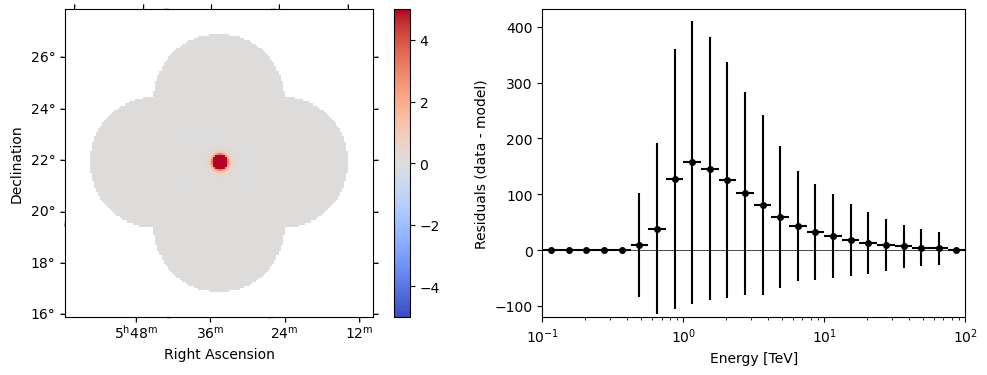

In [18]:
dataset_cor_N.plot_residuals()